In [27]:
# Examine base case results
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import gsw
import cmocean
import utide
from pandas import date_range
import sys
sys.path.append(os.path.abspath('../TEF'))
import TEF_Variables as tef

In [2]:
def along_fjord_state(file):

    file0 = xr.open_dataset(file)
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(X=range(200), Xp1=range(201), Y=range(35,45), Yp1=range(35,45)) # confine to the fjord domain
    
    time = state.T.data
    X = state.X.data 
    x_dist = X / 1000
    depth = state.Z.data
    pres = gsw.p_from_z(depth, -48.25)
    pt = state.Temp.data.mean(2) # Y-axis average
    s = state.S.data.mean(2)
    #p = np.tile(pres,[len(X),1]).T
    p = np.broadcast_to(pres[np.newaxis, :, np.newaxis], pt.shape)
    rho = gsw.rho(s, pt, p)
    
    # Along-fjord velocity
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
    
    # Vetical velocity
    W0 = state.W.data
    bt = np.zeros((W0.shape[0],1,W0.shape[2],W0.shape[3])) # Add vertical velocity (0 m/s) at the bottom
    W = np.concatenate((W0, bt), axis=1)
    wzy = (W[:,1:,:,:] + W[:,:-1,:,:]) / 2
    w = wzy.mean(2)
    
#     # Initial temp and mask
#     pt0 = state.Temp.data.mean(2)[0,:,:]
#     mask = (pt0 == 0)
#     pt[mask] = np.nan
#     s[mask] = np.nan
#     rho[mask] = np.nan
#     u[mask] = np.nan
#     w[mask] = np.nan
    
        
    return (x_dist, depth, time, pt, s, rho, u, w)

In [ ]:
def cross_fjord_state(file, xid):

    file0 = xr.open_dataset(file)
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(X=range(200), Xp1=range(201), Y=range(35,45), Yp1=range(35,46)) # confine to the fjord domain
    
    time = state.T.data
    y_dist = state.Y.data - 25500 
    depth = state.Z.data
    pres = gsw.p_from_z(depth, -48.25)
    pt = state.Temp.data[:,:,:,xid]
    s = state.S.data[:,:,:,xid]
    p = np.broadcast_to(pres[np.newaxis, :, np.newaxis], pt.shape)
    rho = gsw.rho(s, pt, p)
    
    # Along-fjord velocity
    u0 = (state.U.data[:, :, :, :] + state.U.data[:, :, :, :]) / 2
    u = u0[:,:,:,xid]
    
    # Cross-fjord velocity
    v0 = state.V.data # dims = T,Z,Yp1,X
    v = (v0[:, :, 1:, xid] + v0[:, :, :-1, xid]) / 2
           
    return (y_dist, depth, time, pt, s, rho, u, v)

In [17]:
input_file = '/work/oceans/wbao/MITgcm_results/jorgemontt/1_Tide_test/state_003.nc'

U0 = [1e-2, 3e-2, 4e-2, 5e-2, 5e-4, 1e-3, 2e-3, 5e-3] # Tidal amplitude at OB, case 001-008

X, Z1, T1, temp1, sal1, den1, u1, w1 = along_fjord_state(input_file)
# xid = 20
# Y, Z2, T2, temp2, sal2, den2, u2, v2 = cross_fjord_state(input_file, xid)

In [ ]:
file0 = xr.open_dataset(input_file)
A = file0.Y.data
B = file0.Yp1.data
A[35:45], B[35:45]

In [ ]:
# Y.shape, Z2.shape, u2. shape, v2.shape
X[60:70]

Text(0.5, 0, 'Distance from glacier [$km$]')

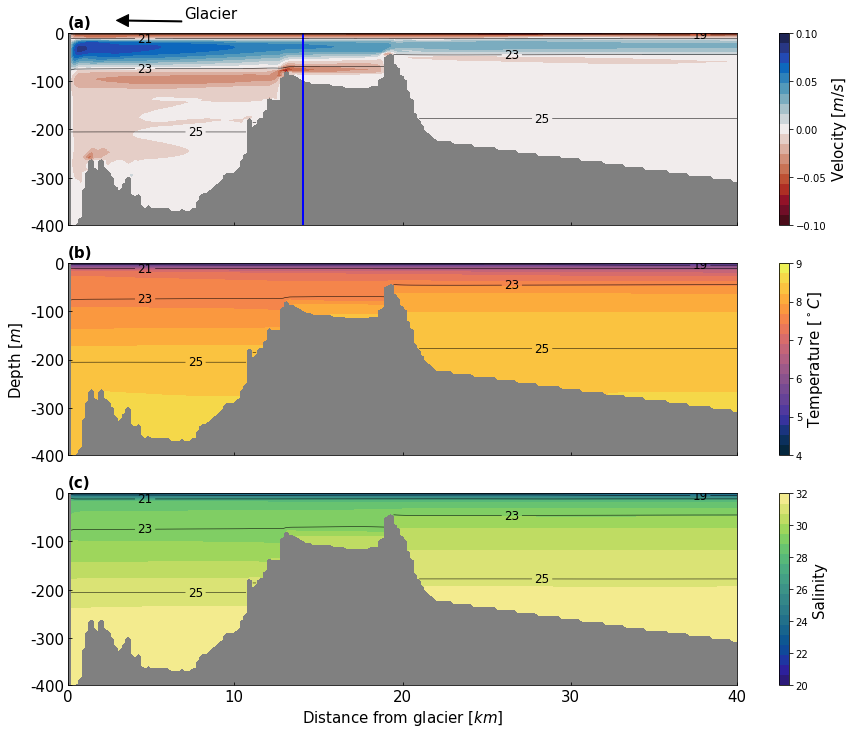

In [25]:
# Plot along-fjord velocity, temperature, and salinity
fig1, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(15,12))

t0 = 10

U, Temp, Sal, RhoA = u1.mean(0), temp1.mean(0), sal1.mean(0), den1.mean(0)-1000
pt0 = temp1[0,:,:]
mask = (pt0 == 0)
U[mask] = np.nan
Temp[mask] = np.nan
Sal[mask] = np.nan
RhoA[mask] = np.nan


cr_u = np.linspace(-0.1,0.1,20) # Contour range
cr_t = np.linspace(4,9,20)
cr_s = np.linspace(20,32,20)
cr_rho = np.linspace(1017,1027,6)-1000

# Along-fjord velocity
im1 = ax1.contourf(X, Z1, U, cr_u, cmap=cmocean.cm.balance_r) 
ax1.axvline(x=X[70], color='b',lw=2)
CS1 = ax1.contour(X,Z1,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS1, fontsize=12, inline=1)

cbar1 = fig1.colorbar(im1,ax=ax1)
cbar1.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar1.set_label('Velocity [$m/s$]', size=15)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=15)
#ax1.xaxis.set_visible(False)
ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([Z1[0], -100, -200, -300, Z1[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
#ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=15, weight='bold')

ax1.annotate('Glacier', xy=(3,25), xytext=(7,29), 
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15, annotation_clip=False)


# Potential temperature
im2 = ax2.contourf(X, Z1, Temp, cr_t, cmap=cmocean.cm.thermal) 
#ax2.axvline(x=x_dist[120], color='g',lw=2)
CS2 = ax2.contour(X,Z1,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS2, fontsize=12, inline=1)

cbar2 = fig1.colorbar(im2,ax=ax2)
cbar2.set_ticks([4,5,6,7,8,9])
cbar2.set_label('Temperature [$^\circ C$]', size=15)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=15)
ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([Z1[0], -100, -200, -300, Z1[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=15)
ax2.set_title(r'(b)', loc='left', size=15, weight='bold')



# Salinity
im3 = ax3.contourf(X, Z1, Sal, cr_s, cmap=cmocean.cm.haline)
#ax1.axvline(x=x_dist[120], color='g',lw=2)
CS3 = ax3.contour(X,Z1,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS3, fontsize=12, inline=1)

cbar3 = fig1.colorbar(im3,ax=ax3)
cbar3.set_ticks([20,22,24,26,28,30,32])
cbar3.set_label('Salinity', size=15)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=15)
ax3.set_yticks([Z1[0], -100, -200, -300, Z1[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=15, weight='bold')
ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
ax3.set_xticklabels(["0","10","20","30","40"])
ax3.set_xlabel('Distance from glacier [$km$]', size=15)

NameError: name 'u2' is not defined

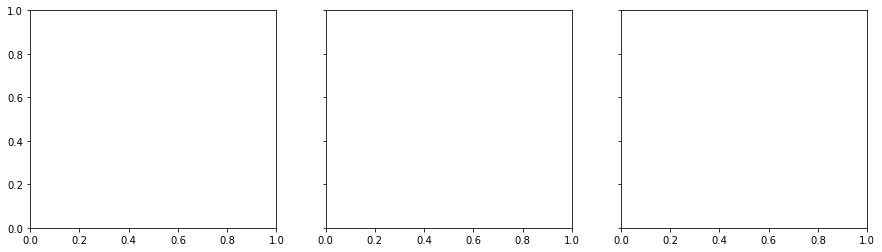

In [24]:
# Plot cross-fjord velocity, temperature, and salinity
fig2, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(15,4))

U2, Temp2, Sal2, RhoA2 = u2.mean(0), temp2.mean(0), sal2.mean(0), den2.mean(0)-1000
pt1 = temp2[0,:,:]
mask = (pt1 == 0)
U2[mask] = np.nan
Temp2[mask] = np.nan
Sal2[mask] = np.nan
RhoA2[mask] = np.nan

# import cmocean
# cr_u = np.linspace(-0.1,0.1,20) # Contour range
# cr_t = np.linspace(4,9,20)
# cr_s = np.linspace(20,32,20)
# cr_rho = np.linspace(1017,1027,6)-1000

# Along-fjord velocity
im1 = ax1.contourf(Y, Z2, U2, cr_u, cmap=cmocean.cm.balance_r) 
#ax1.axvline(x=x_dist[120], color='g',lw=2)
CS1 = ax1.contour(Y,Z2,RhoA2,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS1, fontsize=12, inline=1)

cbar1 = fig2.colorbar(im1,ax=ax1)
cbar1.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar1.set_label('Velocity [$m/s$]', size=15)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=15)
#ax1.xaxis.set_visible(False)
ax1.set_yticks([Z2[0], -100, -200, -300, Z2[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=15, weight='bold')
ax1.set_xticks([Y[0], (Y[0]+Y[-1])/2, Y[-1]])
ax1.set_xticklabels(["0","1","2"])

# Potential temperature
im2 = ax2.contourf(Y, Z2, Temp2, cr_t, cmap=cmocean.cm.thermal) 
#ax2.axvline(x=x_dist[120], color='g',lw=2)
CS2 = ax2.contour(Y,Z2,RhoA2,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS2, fontsize=12, inline=1)

cbar2 = fig2.colorbar(im2,ax=ax2)
cbar2.set_ticks([4,5,6,7,8,9])
cbar2.set_label('Temperature [$^\circ C$]', size=15)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=15)
#ax2.xaxis.set_visible(False)
ax2.set_yticks([Z2[0], -100, -200, -300, Z2[-1]])
#ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_title(r'(b)', loc='left', size=15, weight='bold')
ax2.set_xticks([Y[0], (Y[0]+Y[-1])/2, Y[-1]])
ax2.set_xticklabels(["0","1","2"])
ax2.set_xlabel('Cross-fjord Distance [$km$]', size=15)


# Salinity
im3 = ax3.contourf(Y, Z2, Sal2, cr_s, cmap=cmocean.cm.haline)
#ax1.axvline(x=x_dist[120], color='g',lw=2)
CS3 = ax3.contour(Y,Z2,RhoA2,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS3, fontsize=12, inline=1)

cbar3 = fig2.colorbar(im3,ax=ax3)
cbar3.set_ticks([20,22,24,26,28,30,32])
cbar3.set_label('Salinity', size=15)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=15)
ax3.set_yticks([Z2[0], -100, -200, -300, Z2[-1]])
#ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=15, weight='bold')
ax3.set_xticks([Y[0], (Y[0]+Y[-1])/2, Y[-1]])
ax3.set_xticklabels(["0","1","2"])

In [ ]:
t = date_range(start="2023-10-01", periods=len(T1), freq="H")
#print(t)

In [18]:
# Use UTide to check tidal velocity   
State01 = xr.open_dataset(input_file)    
State = State01.isel(T=~State01.get_index("T").duplicated())
state = State.isel(Y=range(35,45), Yp1=range(35,45))

xloc = 70 # Midfjord mooring
U = state.U.data[:,:,:,xloc].mean(2)
V = state.V.data[:,:,:,xloc].mean(2)
model_time = T1
made_time = date_range(start="2023-10-01", periods=len(T1), freq="H")
  
# In the vertical
Ut_max = np.empty(U.shape[1])
Ut_min = np.empty(U.shape[1])
for z in range(U.shape[1]):        
    coef = utide.solve(
        made_time, U[:,z], V[:,z],
        lat=-48.25,
        nodal=False,
        trend=False,
        method='ols',
        conf_int='linear',
        Rayleigh_min=0.95,
    )
        
    tide = utide.reconstruct(made_time, coef)
    Ut_max[z] = tide['u'].max()
    Ut_min[z] = tide['u'].min()

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ..

/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/utide/confidence.py:250: RuntimeWarning: invalid value encountered in double_scalars
  varXv = Pvv[c] * varXv / den
/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/utide/confidence.py:251: RuntimeWarning: invalid value encountered in double_scalars
  varYv = Pvv[c] * varYv / den
/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/utide/diagnostics.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  PE = (100 / np.sum(E)) * E
/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/utide/diagnostics.py:10: RuntimeWarning: invalid value encountered in multiply
  PE = (100 / np.sum(E)) * E
/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/utide/_reconstruct.py:110: RuntimeWarning: invalid value encountered in true_divide
  PE = 100 * E / E.sum()


done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/ca

In [19]:
ut = np.concatenate((Ut_max, Ut_min))
print (ut, ut.max(), ut.min())

[ 1.69235020e-02  1.61458427e-02  1.57559071e-02  1.98805565e-02
  2.40468595e-02  3.08030724e-02  4.24855834e-02  5.46147102e-02
  6.19545654e-02  7.13289159e-02  7.96279004e-02  8.61250870e-02
  9.10928937e-02  9.38578680e-02  9.48133276e-02  9.46887571e-02
  9.35100632e-02  9.16709843e-02  8.92266283e-02  8.47218797e-02
  8.02353944e-02  7.12239449e-02  6.05001114e-02  4.97584917e-02
  4.15422362e-02  3.33365621e-02  2.65807553e-02  1.91897917e-02
  9.21986095e-03  1.02471772e-03 -2.34101630e-03  4.55718596e-03
  4.00156372e-02  3.95868783e-02  2.22979388e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [20]:
def volflux_ts(file, xidx):
    State01 = xr.open_dataset(file)
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(Y=range(35,45), Yp1=range(35,45))
    Grid = xr.open_dataset('/work/oceans/wbao/MITgcm_results/jorgemontt/1_Tide_test/grid_005.nc')
    grid = Grid.isel(Y=range(35,45), Yp1=range(35,45))    
    
    time = state.T.data / 86400
    
    Area = np.empty([90, 10]) # Cross Y direction
    Area[:20, :] = 400
    Area[20:50, :] = 800
    Area[50:, :] = 1200

    HFacW = grid.HFacW.data[:,:,xidx] # vertical fraction of open cell at West face
    
    Q1 = np.empty(len(time))
    Q2 = np.empty(len(time))
    for t in range(len(time)):
        Q = state.U.data[t,:,:,xidx] * Area * HFacW
        Q1[t] = Q[Q > 0].sum()
        Q2[t] = Q[Q < 0].sum()
    
    return time, Q1, Q2

In [21]:
Day, Q1, Q2 = volflux_ts(input_file, 70)

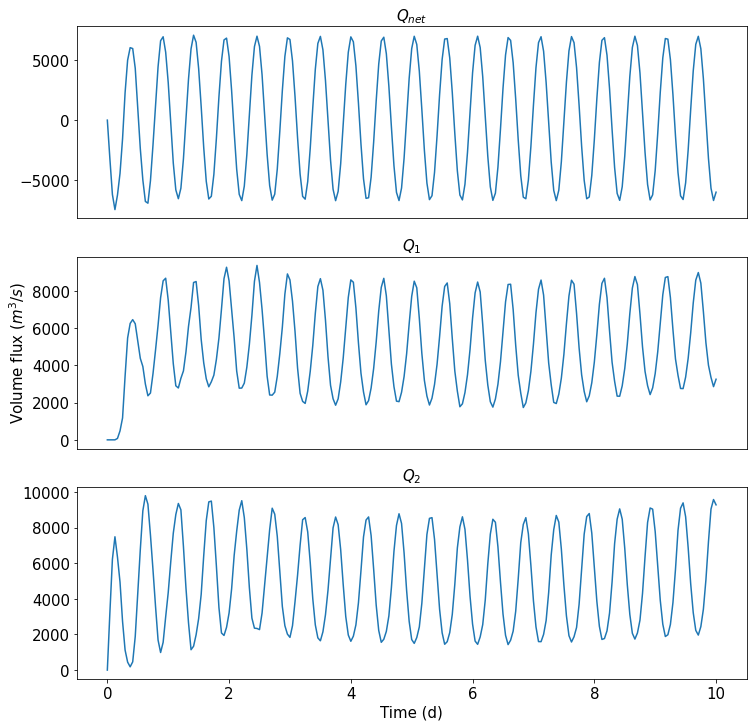

In [22]:
# making along-fjord volume flux plot
fig3, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12)) 
ax1.plot(Day,Q1+Q2, label=r'$Q_{net}$')
#ax1.plot(time,Q2in+Q2out, label='ConserveMass ON')
ax1.set_title('$Q_{net}$', size=15, weight='bold')
#ax1.legend(loc = 'best', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_visible(False)


ax2.plot(Day,Q1, label='Q1')
ax2.set_title('$Q_1$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.xaxis.set_visible(False)
ax2.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax3.plot(Day,-Q2, label='Q2')
#ax3.plot(time,Q2in, label='ConserveMass ON')
#ax3.axvline(x=275, color='b',lw=2)
ax3.set_title('$Q_2$', size=15, weight='bold')
#ax3.legend(loc = 'best', fontsize=15)
ax3.tick_params(labelsize=15)

ax3.set_xlabel('Time (d)', size=15)
plt.show()

In [23]:
Q1.mean(), Q2.mean(), np.mean(Q1+Q2)

(4972.41822982308, -4945.636824490913, 26.781405332167605)

In [28]:
## TEF
def tef_transport(case_id, xi):    
    File1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/jorgemontt/1_Tide_test/state_' + str(format(case_id,'03d')) + '.nc')
    State = File1.isel(T=~File1.get_index("T").duplicated())
#    Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/1_BaseCase/grid_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset('/work/oceans/wbao/MITgcm_results/jorgemontt/1_Tide_test/grid_' + str(format(case_id,'03d')) + '.nc')

    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    s = state.S.data.mean(2) # Salinity in T,Z,X
    u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
    ot = state.T.data # Time in seconds


    HFacC1 = grid.HFacC.data.mean(1)
    dyF1 = grid.dyF.data.mean(0)
    drF1 = grid.drF.data
    gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
    da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

    S = state.S.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    
#     Qin = np.empty(len(xi))
#     Qout = np.empty(len(xi))
#     Sin = np.empty(len(xi))
#     Sout = np.empty(len(xi))
    
#     t0 = 89 # 274
#     # Exclude the upper (surface) layer for TEF calculation
#     for t in range(U.shape[0]):
        
#         Uzx = u[t,:,:] # Steady-state along-channel velocity
#         for j in range(Uzx.shape[1]):
#             if any(Uzx[:,j]>0)==False:
#                 pass
#             else:
#                 mid = np.where(Uzx[:,j]>0)[0][0]
#                 if mid>0:
#                     S[t,:mid,:,j] = 0
#                     U[t,:mid,:,j] = 0
#                 else:
#                     pass

    
    
               
    tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1 = tef.process_section(U,S,DA,ot,xi,23,testing=False)

    Qin, Qout, Sin, Sout = tef.bulk_calc(tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1, ot)
    
#     Qin[i] = qin1[t0:].mean() # Time averaging from 1+t0 hour
#     Qout[i] = qout1[t0:].mean()
#     Sin[i] = sin1[t0:].mean() # Time averaging from 1+t0 hour
#     Sout[i] = sout1[t0:].mean()
        
    return Qin, Qout, Sin, Sout

In [38]:
def godin_shape():
    """
    Based on matlab code of 4/8/2013  Parker MacCready
    Returns a 71 element numpy array that is the weights
    for the Godin 24-24-25 tildal averaging filter. This is the shape given in
    Emery and Thomson (1997) Eqn. (5.10.37)
    ** use ONLY with hourly data! **
    """
    k = np.arange(12)
    filt = np.NaN * np.ones(71)
    filt[35:47] = (0.5/(24*24*25))*(1200-(12-k)*(13-k)-(12+k)*(13+k))
    k = np.arange(12,36)
    filt[47:71] = (0.5/(24*24*25))*(36-k)*(37-k)
    filt[:35] = filt[:35:-1]
    return filt

def filt_godin(data):
    """
    Input: 1D numpy array of HOURLY values
    Output: Array of the same size, filtered with 24-24-25 Godin filter,
        padded with nan's
    """
    filt = godin_shape()
    npad = np.floor(len(filt)/2).astype(int)
    smooth = np.convolve(data, filt, mode = 'same')
    smooth[:npad] = np.nan
    smooth[-npad:] = np.nan
    # smooth[:npad] = data[:npad]
    # smooth[-npad:] = data[-npad:]
    return smooth

In [44]:
Qin, Qout, Sin, Sout = tef_transport(4, )

  time 0 out of 240


/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:268: RuntimeWarning: invalid value encountered in true_divide
  Sp = QSp/Qp
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:272: RuntimeWarning: invalid value encountered in true_divide
  S2p = QS2p/Qp


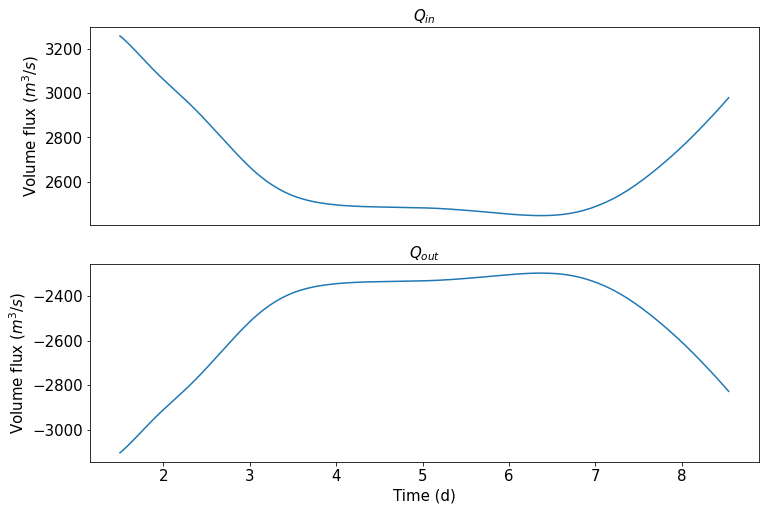

In [45]:
# making TEF transports plot
fig4, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,8)) 
ax1.plot(Day[1:],filt_godin(Qin), label=r'$Q_{in}$')
#ax1.plot(time,Q2in+Q2out, label='ConserveMass ON')
ax1.set_title('$Q_{in}$', size=15, weight='bold')
#ax1.legend(loc = 'best', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('Volume flux ($m^3/s$)', size=15)


ax2.plot(Day[1:],filt_godin(Qout), label=r'$Q_{out}$')
ax2.set_title('$Q_{out}$', size=15, weight='bold')
#ax2.legend(loc = 'best', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Time (d)', size=15)
ax2.set_ylabel('Volume flux ($m^3/s$)', size=15)


plt.show()

In [43]:
np.mean(Qin+Qout)

-3.0222133961054474